In [8]:
!pip install --user --upgrade tensorflow
!pip install ipython[all]

/usr/local/anaconda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/local/anaconda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached tensorflow-2.6.0-cp37-cp37m-manylinux2010_x86_64.whl (458.3 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached grpcio-1.39.0-cp37-cp37m-manylinux2014_x86_64.whl (4.3 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached clang-5.0-py3-none-any.whl
  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Usin

In [5]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.compat.v2.feature_column as fc
from Ipython.display import clear_output
from size.moves import urlib


2.6.0


ModuleNotFoundError: No module named 'Ipython'

In [16]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [21]:
# change all categorical columns into 0,1,2

CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

(pd.DataFrame(feature_columns))

,key,vocabulary_list,dtype,default_value,num_oov_buckets
0,sex,"(male, female)",<dtype: 'string'>,-1,0.0
1,n_siblings_spouses,"(1, 0, 3, 4, 2, 5, 8)",<dtype: 'int64'>,-1,0.0
2,parch,"(0, 1, 2, 5, 3, 4)",<dtype: 'int64'>,-1,0.0
3,class,"(Third, First, Second)",<dtype: 'string'>,-1,0.0
4,deck,"(unknown, C, G, A, B, D, F, E)",<dtype: 'string'>,-1,0.0
5,embark_town,"(Southampton, Cherbourg, Queenstown, unknown)",<dtype: 'string'>,-1,0.0
6,alone,"(n, y)",<dtype: 'string'>,-1,0.0
7,age,"(1,)",None,<dtype: 'float32'>,NaN
8,fare,"(1,)",None,<dtype: 'float32'>,NaN


In [22]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [26]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier
linear_est.train(train_input_fn)
result=linear_est.evaluate(eval_input_fn)
print(result['accuracy'])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmprbryqxr9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:ten

In [30]:
linear_est

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmprbryqxr9/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


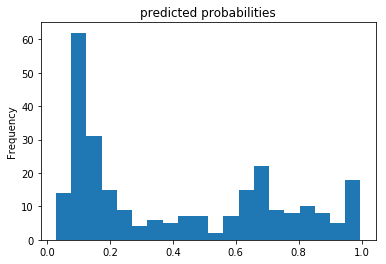

In [29]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [15]:
from Ipython.display import clear_output


ModuleNotFoundError: No module named 'Ipython'